Biểu diễn feature vector với iterator 80000:

https://colab.research.google.com/drive/1PC8BGeNZOjrBIzR_gQRTQ65RWlA4NpQb?usp=sharing&fbclid=IwZXh0bgNhZW0CMTEAAR5Mk0fMQsM0nldj-uIyBtYTTKMOs8s6k4ajzrCu4aBqp0DLYxWQGDKg3mt31A_aem_Ef37gduL8VXRDipndfJQ1w

In [ ]:
!git clone https://github.com/an2101/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (33/33), 54.53 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (3/3), done.


**Cấu hình lại mô hình, vào content/GaitSet/config.py:  
-Sửa 'dataset_path': /content/preprocessed thành /content/preprocessed2  
-Sửa 'pid_num': 73 thành 'pid_num': 9  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/pbl4/preprocessed2.zip"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-069.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-070.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-071.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-072.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-073.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-074.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-075.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-076.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-077.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-078.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-079.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-080.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-081.png  
 extracting: preprocessed2/020/nm-01/054/020-nm-01-054-082.png  
 extracting: preprocessed2/020/nm

In [ ]:
from GaitSet.model.network.gaitset import SetNet
import torch.optim as optim
import torch.nn as nn
import torch
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
import umap.umap_ as umap

In [ ]:
encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

model_name = 'GaitSet'
encoder.load_state_dict(torch.load('/content/GaitSet/work/checkpoint/GaitSet/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-95400-encoder.ptm'))

<All keys matched successfully>

In [ ]:
encoder.eval()

DataParallel(
  (module): SetNet(
    (set_layer1): SetBlock(
      (forward_block): BasicConv2d(
        (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
    )
    (set_layer2): SetBlock(
      (forward_block): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (set_layer3): SetBlock(
      (forward_block): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (set_layer4): SetBlock(
      (forward_block): BasicConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (set_layer5): SetBlock(
      (forward_block): BasicConv2d(
        (conv): Conv2d(64, 128, k

In [ ]:
from GaitSet.config import conf
print("Dataset path is:", conf["data"]["dataset_path"])


Dataset path is: /content/preprocessed2


In [ ]:
from GaitSet.model.initialization import initialize_data
from GaitSet.config import conf

train_source, test_source = initialize_data(conf, train = False, test = True)

Initializing data source...
Loading test data...
Data initialization complete.


In [ ]:
from copy import deepcopy
import numpy as np

# train_source, test_source = initialize_data(conf, train = False, test = False)
data_config = conf['data']
model_config = conf['model']
model_param = deepcopy(model_config)
model_param['train_source'] = None
model_param['test_source'] = test_source
model_param['train_pid_num'] = data_config['pid_num']
batch_size = int(np.prod(model_config['batch_size']))
model_param['save_name'] = '_'.join(map(str,[
    model_config['model_name'],
    data_config['dataset'],
    data_config['pid_num'],
    data_config['pid_shuffle'],
    model_config['hidden_dim'],
    model_config['margin'],
    batch_size,
    model_config['hard_or_full_trip'],
    model_config['frame_num'],
]))
restore_iter = 95400

In [ ]:
import torch.utils.data as tordata
from GaitSet.model.model import Model

model = Model(**model_param)
data_loader = tordata.DataLoader(
            dataset=test_source,
            batch_size=1,
            sampler=tordata.sampler.SequentialSampler(test_source),
            collate_fn=model.collate_fn,
            num_workers=model.num_workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
feature_list = list()
view_list = list()
seq_type_list = list()
label_list = list()
for i, data in enumerate(data_loader):
    seq, view, seq_type, label, batch_frame = data

    seq[0] = model.np2var(seq[0])
    batch_frame = model.np2var(batch_frame)

    feature, _ = encoder(*seq, batch_frame)
    feature_list.append(feature.view(1, -1).data.cpu().numpy())
    view_list += view
    seq_type_list += seq_type
    label_list += label

In [ ]:
data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
feature, view, seq_type, label = data
label = np.array(label)
view_list = list(set(view))
view_list.sort()
view_num = len(view_list)
sample_num = len(feature)

In [ ]:
sample_num

1100

In [ ]:
len(feature[0])

15872

In [ ]:
feature.shape

(1100, 15872)

In [ ]:
def plot_feature(type):

    colors = plt.cm.tab20(np.linspace(0, 1, 21))

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    pca = PCA(n_components=2)
    reducer = umap.UMAP(n_components=2, random_state=42)

    if type == 'umap':
        clusters = reducer.fit_transform(feature)
    elif type == 'pca':
        clusters = pca.fit_transform(feature)
    else: #tsne
        clusters = tsne.fit_transform(feature)
    # Create one figure for all plots
    plt.figure(figsize=(8, 8))

    for i in range(1100):
        x = clusters[i, 0]
        y = clusters[i, 1]
        plt.scatter(x, y, color=colors[int(label[i]) ], s=5)
    plt.grid(True)
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
<ipython-input-32-628d3725854d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


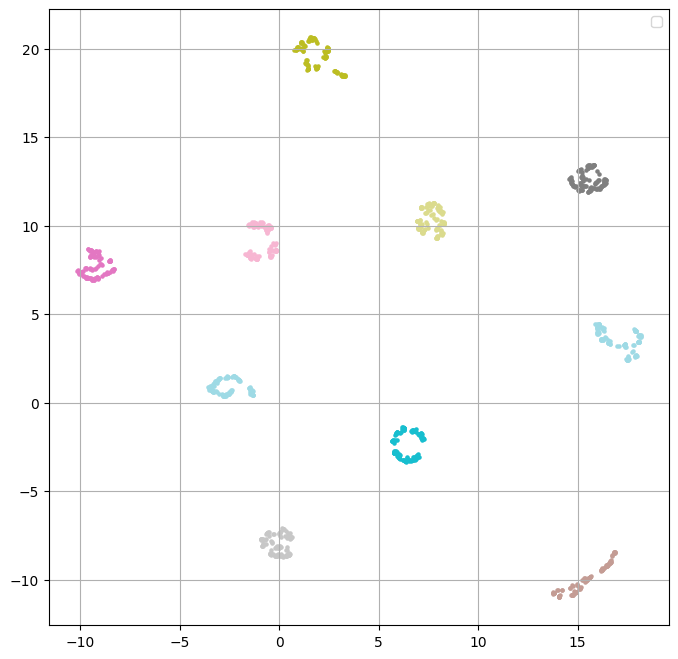

In [ ]:
plot_feature('umap') #tìm hiểu train và test là ngẫu nhiên hay giống nhau mỗi lần

<ipython-input-32-628d3725854d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


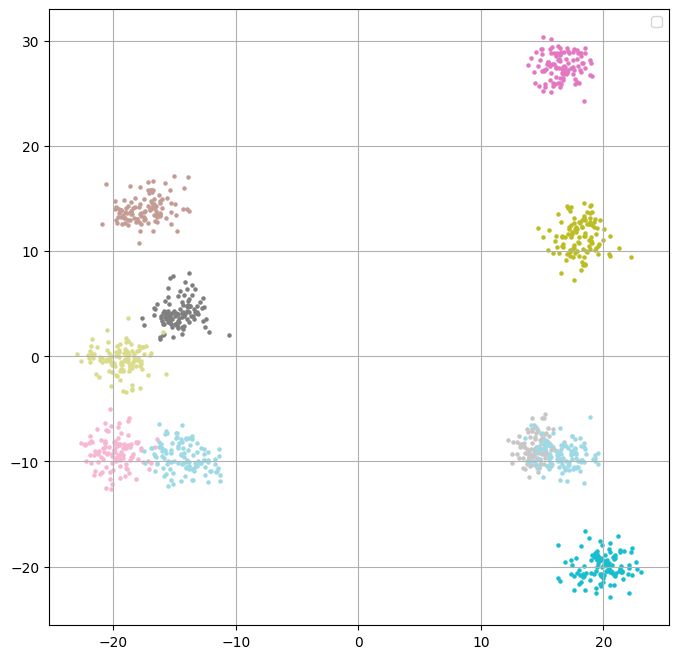

In [ ]:
plot_feature('pca')

<ipython-input-32-628d3725854d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


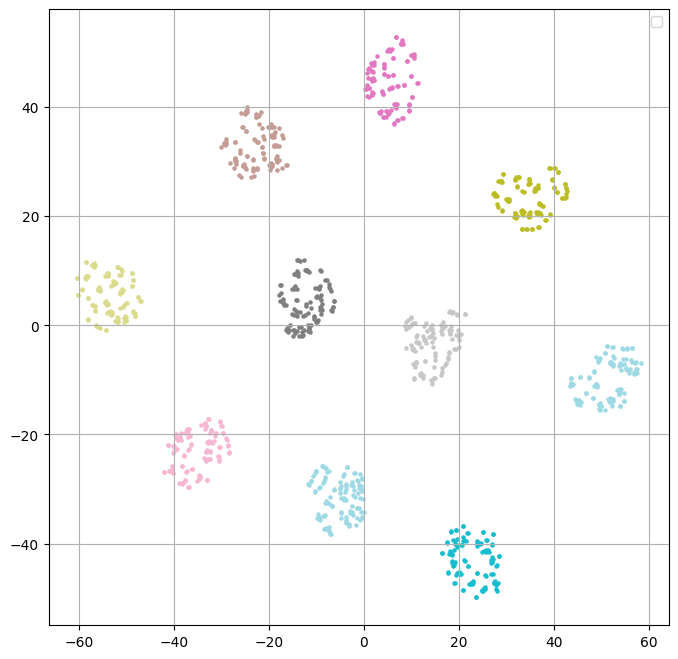

In [ ]:
plot_feature('tsne')

In [ ]:
probe_seq_dict =  [['nm-05', 'nm-06'], ['bg-01', 'bg-02'], ['cl-01', 'cl-02']]
gallery_seq_dict = [['nm-01', 'nm-02', 'nm-03', 'nm-04']]

In [ ]:
def euclid_dist(a, b):
    a2 = np.sum(a**2, axis=1, keepdims=True)
    b2 = np.sum(b**2, axis=1, keepdims=True)
    dist = a2 + b2.T - 2 * a @ b.T
    dist = np.sqrt(np.maximum(0, dist))
    return dist


In [ ]:
acc = np.zeros([len(probe_seq_dict), view_num, view_num])
for (p, probe_seq) in enumerate(probe_seq_dict):
    for gallery_seq in gallery_seq_dict:
        for (v1, probe_view) in enumerate(view_list):
            for (v2, gallery_view) in enumerate(view_list):
                gseq_mask = np.isin(view, gallery_view) & np.isin(seq_type, gallery_seq)
                pseq_mask = np.isin(view, probe_view) & np.isin(seq_type, probe_seq)

                gseq = feature[gseq_mask]  # 32, (62 x 256)
                pseq = feature[pseq_mask]   # 16, (62 x 256)

                dist = euclid_dist(pseq, gseq) # 16, 32
                idx = np.argmin(dist, axis=1)  # 16

                gseq_label = label[gseq_mask]  # 32,
                pseq_label = label[pseq_mask]  # 16,
                # print(idx)
                # print(np.sum(gseq_label[idx] == pseq_label) * 100 / 16)
                acc[p, v1, v2] = np.sum(gseq_label[idx] == pseq_label) * 100 / 16

    #             break
    #         break
    #     break
    # break





In [ ]:
print(acc)

[[[125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]]

 [[125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 125.]
  [125. 125. 125. 125. 125. 125. 125. 125. 125. 125. 1